# Hourly Forecasting Carbon Intensity using SARIMA #

## Importing modules ##

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pmdarima as pm
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import time
import sys, os
import time

    
# Set thread limits
os.environ['OMP_NUM_THREADS'] = '4'
os.environ['MKL_NUM_THREADS'] = '4'
    
sys.path.append(os.path.abspath('../../LibreHardwareMonitor-net472'))
from power_monitor import PowerMonitor
    
# Dictionary to store execution times for each code block
execution_times = {}
power_stats = {}


In [2]:
with PowerMonitor(filename = "subset_hourly_SARIMA.csv") as pmon:
    start_time = time.time()
    df = pd.read_csv('../../data/df_fuel_ckan.csv')
    df['DATETIME'] = pd.to_datetime(df['DATETIME'])

    # Filter for history and the test year (2025)
    df_filtered = df[df['DATETIME'].dt.year < 2025].copy().set_index('DATETIME')
    df_2025 = df[df['DATETIME'].dt.year == 2025].copy().set_index('DATETIME')

    # Use 30 days for balance between speed and accuracy
    data_train = df_filtered['CARBON_INTENSITY'].resample('h').mean().interpolate().tail(24 * 20)
    actual_2025 = df_2025['CARBON_INTENSITY'].resample('h').mean().interpolate()

    def create_time_features(index):
        """Create enhanced time-based features for better pattern capture"""
        df_feat = pd.DataFrame(index=index)
        df_feat['hour'] = index.hour / 23.0  # Normalize to [0,1]
        df_feat['day_of_week'] = index.dayofweek / 6.0
        # IMPROVED: Added more features for better pattern recognition
        df_feat['day_of_month'] = index.day / 31.0
        df_feat['week_of_year'] = index.isocalendar().week / 52.0
        return df_feat.values

    X_train = create_time_features(data_train.index)
    X_future = create_time_features(actual_2025.index)

    scaler_y = StandardScaler()
    y_train_scaled = scaler_y.fit_transform(data_train.values.reshape(-1, 1)).flatten()
    execution_times['import and scaling'] = time.time() - start_time
power_stats['import and scaling'] = pmon.stats()

In [3]:
with PowerMonitor(filename = "subset_hourly_SARIMA.csv") as pmon:
    start_time = time.time()
    stepwise_model = pm.auto_arima(
        y=y_train_scaled,
        X=X_train,
        seasonal=True,
        m=24,
        start_p=1, start_q=1, 
        start_P=0, start_Q=0,
        max_p=3, max_q=2,
        max_P=1, max_Q=1,
        d=None, D=None,
        max_d=2, max_D=1,
        test='adf',
        seasonal_test='ocsb',
        stepwise=False,
        n_jobs=1,
        suppress_warnings=True,
        error_action='ignore',
        information_criterion='aic',
        trace=True,
        with_intercept=False,
        maxiter=50,
        method='lbfgs'
        )
    execution_times['SARIMA'] = time.time() - start_time
power_stats['SARIMA'] = pmon.stats()


 ARIMA(0,1,0)(0,0,0)[24]             : AIC=-579.102, Time=0.05 sec
 ARIMA(0,1,0)(0,0,1)[24]             : AIC=-634.575, Time=1.79 sec
 ARIMA(0,1,0)(1,0,0)[24]             : AIC=-655.821, Time=1.59 sec
 ARIMA(0,1,0)(1,0,1)[24]             : AIC=inf, Time=4.25 sec
 ARIMA(0,1,1)(0,0,0)[24]             : AIC=-801.264, Time=0.63 sec
 ARIMA(0,1,1)(0,0,1)[24]             : AIC=-833.280, Time=1.34 sec
 ARIMA(0,1,1)(1,0,0)[24]             : AIC=-844.956, Time=1.59 sec
 ARIMA(0,1,1)(1,0,1)[24]             : AIC=inf, Time=3.20 sec
 ARIMA(0,1,2)(0,0,0)[24]             : AIC=-831.955, Time=0.64 sec
 ARIMA(0,1,2)(0,0,1)[24]             : AIC=-855.142, Time=2.04 sec
 ARIMA(0,1,2)(1,0,0)[24]             : AIC=-863.659, Time=2.03 sec
 ARIMA(0,1,2)(1,0,1)[24]             : AIC=inf, Time=2.75 sec
 ARIMA(1,1,0)(0,0,0)[24]             : AIC=-815.674, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[24]             : AIC=-838.845, Time=1.03 sec
 ARIMA(1,1,0)(1,0,0)[24]             : AIC=-847.564, Time=1.63 sec
 ARIMA(1,1

In [4]:
with PowerMonitor(filename = "subset_hourly_SARIMA.csv") as pmon:
    start_time = time.time()
    forecast_scaled = stepwise_model.predict(
    n_periods=len(actual_2025),
    X=X_future
    )

    # Inverse transform to original scale
    forecast_values = scaler_y.inverse_transform(forecast_scaled.reshape(-1, 1)).flatten()
    forecast_series = pd.Series(forecast_values, index=actual_2025.index)
    execution_times['Forecasting'] = time.time() - start_time
power_stats['Forecasting'] = pmon.stats()


Performance Metrics:
MAE: 182.70 gCO2/kWh
RMSE: 214.78 gCO2/kWh


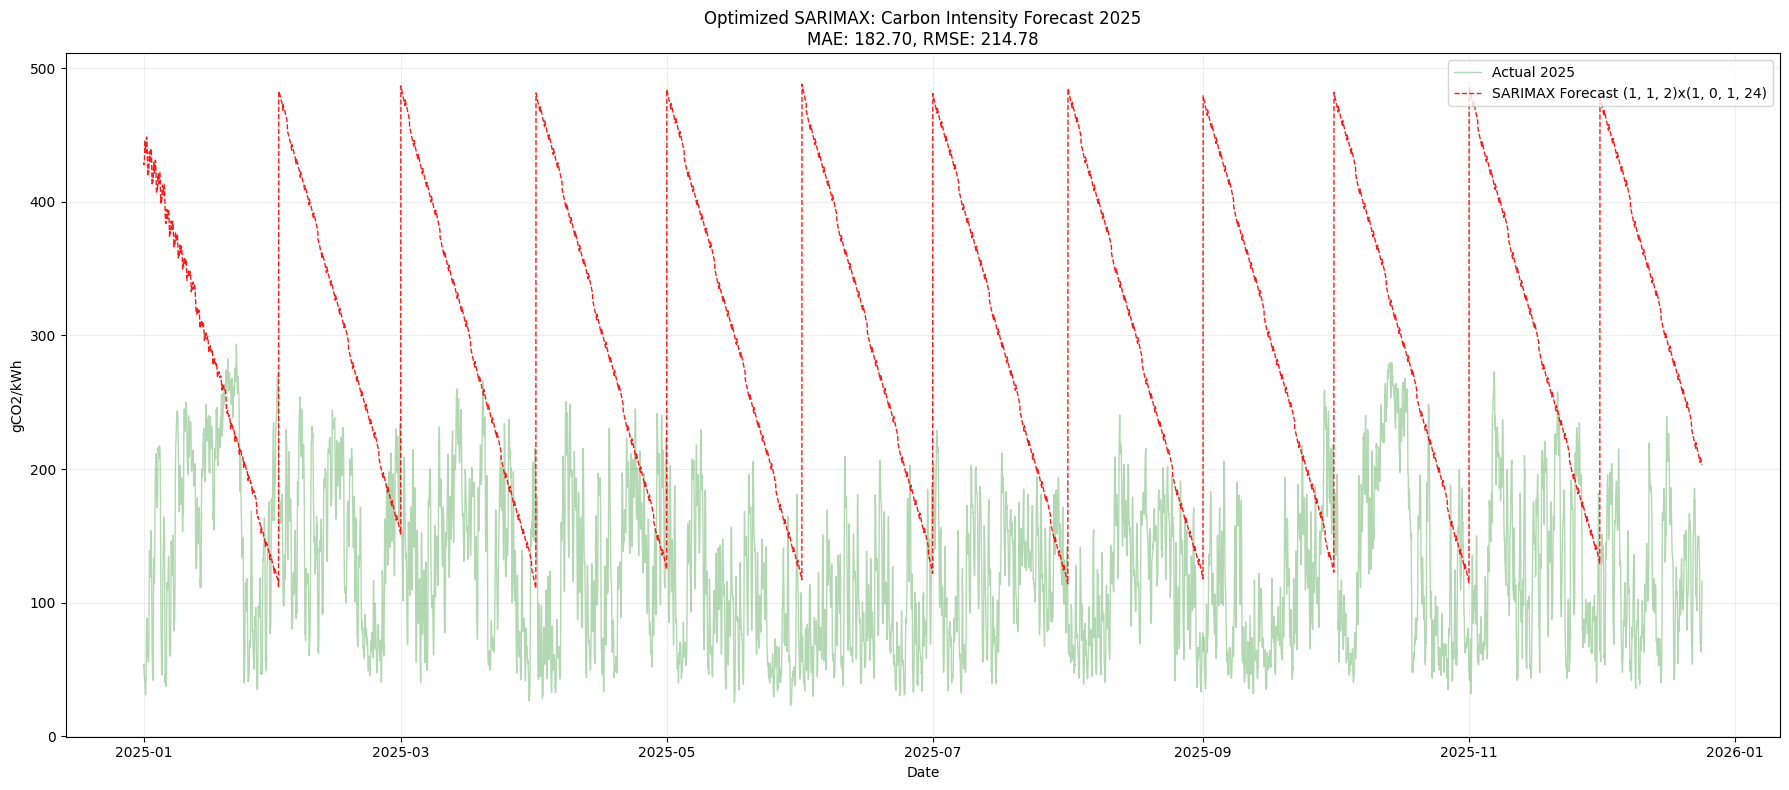

{'import and scaling': 0.8982107639312744, 'SARIMA': 91.55225205421448, 'Forecasting': 0.4121372699737549}


In [5]:
with PowerMonitor(filename = "subset_hourly_SARIMA.csv") as pmon:
     start_time = time.time()
     mae = mean_absolute_error(actual_2025, forecast_series)
     rmse = np.sqrt(mean_squared_error(actual_2025, forecast_series))

     print(f"\nPerformance Metrics:")
     print(f"MAE: {mae:.2f} gCO2/kWh")
     print(f"RMSE: {rmse:.2f} gCO2/kWh")

     plt.figure(figsize=(18, 8))

     # Plot actuals
     plt.plot(actual_2025.index, actual_2025, label='Actual 2025', 
          color='green', alpha=0.3, linewidth=1)

     # Plot forecast
     plt.plot(forecast_series.index, forecast_series, 
          label=f'SARIMAX Forecast {stepwise_model.order}x{stepwise_model.seasonal_order}', 
          color='red', linestyle='--', alpha=0.9, linewidth=1)

     plt.title(f'Optimized SARIMAX: Carbon Intensity Forecast 2025\nMAE: {mae:.2f}, RMSE: {rmse:.2f}')
     plt.xlabel('Date')
     plt.ylabel('gCO2/kWh')
     plt.legend(loc='upper right')
     plt.grid(True, alpha=0.2)

     plt.tight_layout()
     plt.show()
     execution_times['Forecasting'] = time.time() - start_time
     print(execution_times)
power_stats['Forecasting'] = pmon.stats()
     

In [6]:
# Print power usage summary
print("\nPOWER USAGE SUMMARY")
for task, stats in power_stats.items():
    print(f"{task}: {stats}")

# Calculate and print total energy used by the program
print("\n" + "="*50)
print("TOTAL ENERGY USED (Average Power × Runtime)")
print("="*50)

total_energy_joules = 0
for task, stats in power_stats.items():
    if stats and task in execution_times:
        # Sum up average power from all components (CPU Package, CPU Cores, CPU Memory, CPU Platform, GPU Power)
        total_avg_power = 0
        for component, data in stats.items():
            if isinstance(data, dict) and 'avg' in data:
                total_avg_power += data['avg']
        
        runtime = execution_times[task]
        energy = total_avg_power * runtime  # Energy in Joules = Power (Watts) × Time (seconds)
        total_energy_joules += energy
        print(f"{task}: {total_avg_power:.2f}W × {runtime:.4f}s = {energy:.2f}J")

print(f"\nTotal Energy Used: {total_energy_joules:.2f} Joules")
print(f"Total Energy Used: {total_energy_joules/1000:.4f} kJ (kilojoules)")
print("="*50)


POWER USAGE SUMMARY
import and scaling: {'CPU Package': {'min': 21.7399845123291, 'max': 23.422128677368164, 'avg': 22.581056594848633, 'samples': 2}, 'CPU Cores': {'min': 16.675323486328125, 'max': 17.58913230895996, 'avg': 17.132227897644043, 'samples': 2}, 'CPU Memory': {'min': 0.0, 'max': 0.0, 'avg': 0.0, 'samples': 2}, 'CPU Platform': {'min': 0.0, 'max': 0.0, 'avg': 0.0, 'samples': 2}, 'GPU Power': {'min': 0.017838258296251297, 'max': 0.017838258296251297, 'avg': 0.017838258296251297, 'samples': 2}}
SARIMA: {'CPU Package': {'min': 9.625262260437012, 'max': 20.956344604492188, 'avg': 16.441104368198136, 'samples': 163}, 'CPU Cores': {'min': 5.394680976867676, 'max': 19.533323287963867, 'avg': 12.440407867080594, 'samples': 163}, 'CPU Memory': {'min': 0.0, 'max': 0.0, 'avg': 0.0, 'samples': 163}, 'CPU Platform': {'min': 0.0, 'max': 0.0, 'avg': 0.0, 'samples': 163}, 'GPU Power': {'min': 0.005045904312282801, 'max': 0.061578165739774704, 'avg': 0.0123356172066479, 'samples': 163}}
Fo